# **CLIP Explainability**

In [109]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install einops
!pip install ftfy
!pip install captum

Cloning into 'Transformer-MM-Explainability'...
remote: Enumerating objects: 1477, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 1477 (delta 82), reused 69 (delta 60), pack-reused 1373
Receiving objects: 100% (1477/1477), 29.01 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (571/571), done.


# **CLIP**

In [2]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [3]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [4]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1: 
      # calculate index of last lareyer 
      start_layer = len(image_attn_blocks) - 1
    
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1: 
      # calculate index of last layer 
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text
   
    return text_relevance, image_relevance

In [5]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [6]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [7]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

100%|███████████████████████████████████████| 354M/354M [00:39<00:00, 8.86MiB/s]
/home/iai/anaconda3/envs/jwnew/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [10]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

CLIP similarity score: 20.578125
tensor([0.0101, 0.0938, 0.0087, 0.7285, 0.1595], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of tower bottle


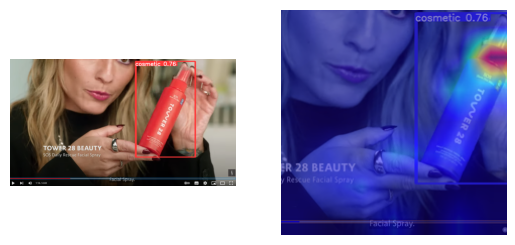

In [17]:
img_path = "/home/iai/Desktop/Jeewon/Git/CosmeticDetector/cap2.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["A photo of tower bottle"]
text = clip.tokenize(texts).to(device)

logits_per_image, logits_per_text = model(img, text)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
#     Text heatmap
  show_heatmap_on_text(texts[i], text[i], R_text[i])
#     Image heatmap
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

In [31]:
def emphasize_attention(image_relevance, image):
    # Create heatmap from attention mask
    def create_heatmap(mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        return heatmap

    # Apply attention-based augmentation
    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())

    # Emphasize attention regions in the image
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    # Apply attention mask to image
    heatmap = create_heatmap(image_relevance)
    
    emphasized_image = (heatmap * image) + ((1 - heatmap) * 255)
    emphasized_image = np.uint8(emphasized_image)

    return emphasized_image


CLIP similarity score: 31.453125
tensor([0.4055, 0.1475, 0.4468, 0.0000], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,bobb i brown mascara


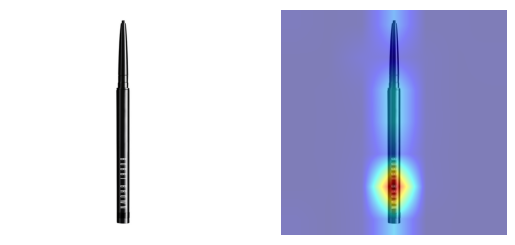

In [33]:
img_path = "/home/iai/Desktop/Jeewon/Git/mascara.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["Bobbi brown mascara"]
text = clip.tokenize(texts).to(device)

logits_per_image, logits_per_text = model(img, text)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
    # Text heatmap
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    
    # Image heatmap
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    
    # Emphasize attention regions in the image
    emphasized_image = emphasize_attention(R_image[i], img)
    
    # Save the augmented image
    augmented_img_path = f"augmented_image_{i}.jpg"
    Image.fromarray(emphasized_image).save(augmented_img_path)


tensor([1.], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,brush


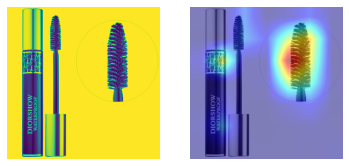

tensor([1.], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,mascara


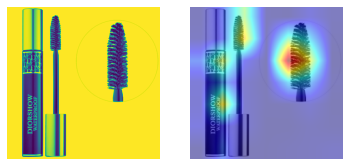

tensor([0.0056, 0.1652, 0.1333, 0.1235, 0.5723], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,di or show waterproof mascara


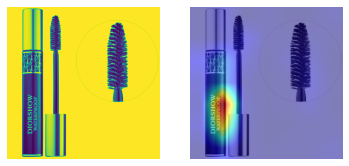

tensor([0.0291, 0.0548, 0.0201, 0.0023, 0.0041, 0.2500, 0.1017, 0.0487, 0.4897],
       device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of a di or show waterproof mascara


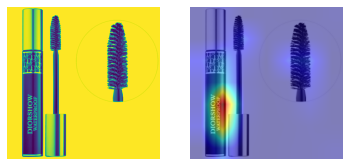

tensor([0.0005, 0.0018, 0.0074, 0.0110, 0.2096, 0.1414, 0.0743, 0.4780, 0.0151,
        0.0095, 0.0065, 0.0012, 0.0117, 0.0035, 0.0072, 0.0109, 0.0050, 0.0019,
        0.0034], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,it is a di or show waterproof mascara and the name of it is written on the package .


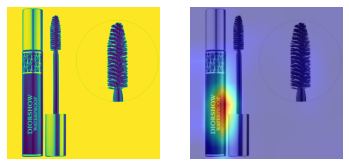

In [136]:
img_path = "/workspace/clip_model/diorshow.jpeg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["brush","mascara","Diorshow Waterproof Mascara", "a photo of a Diorshow Waterproof Mascara", "It is a Diorshow Waterproof Mascara and the name of it is written on the package."]
text = clip.tokenize(texts).to(device)


R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()